In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torch
import seaborn as sns

from numpy.random import dirichlet
from scipy.stats import spearmanr, pearsonr
from torch.nn.functional import softmax
from sklearn.preprocessing import MinMaxScaler


sns.set_theme(font="serif")

In [101]:
# # parameters
# alpha = 0.1
# domain_size = 100
# scaling = 42
# noise = 0.142
# seed = 42

# # sampling
# num_corpora = 100
# num_per_corpus = 100000


# # typicality
# epsilon = 0.01

In [160]:
# parameters
alpha = 0.1
domain_size = 1000
scaling = 42
noise = 0.42
seed = 42

# sampling
num_corpora = 1000
num_per_corpus = 100_000
num_bins = 10
num_corpora_per_bin = num_corpora // num_bins

# typicality
epsilon = 0.001

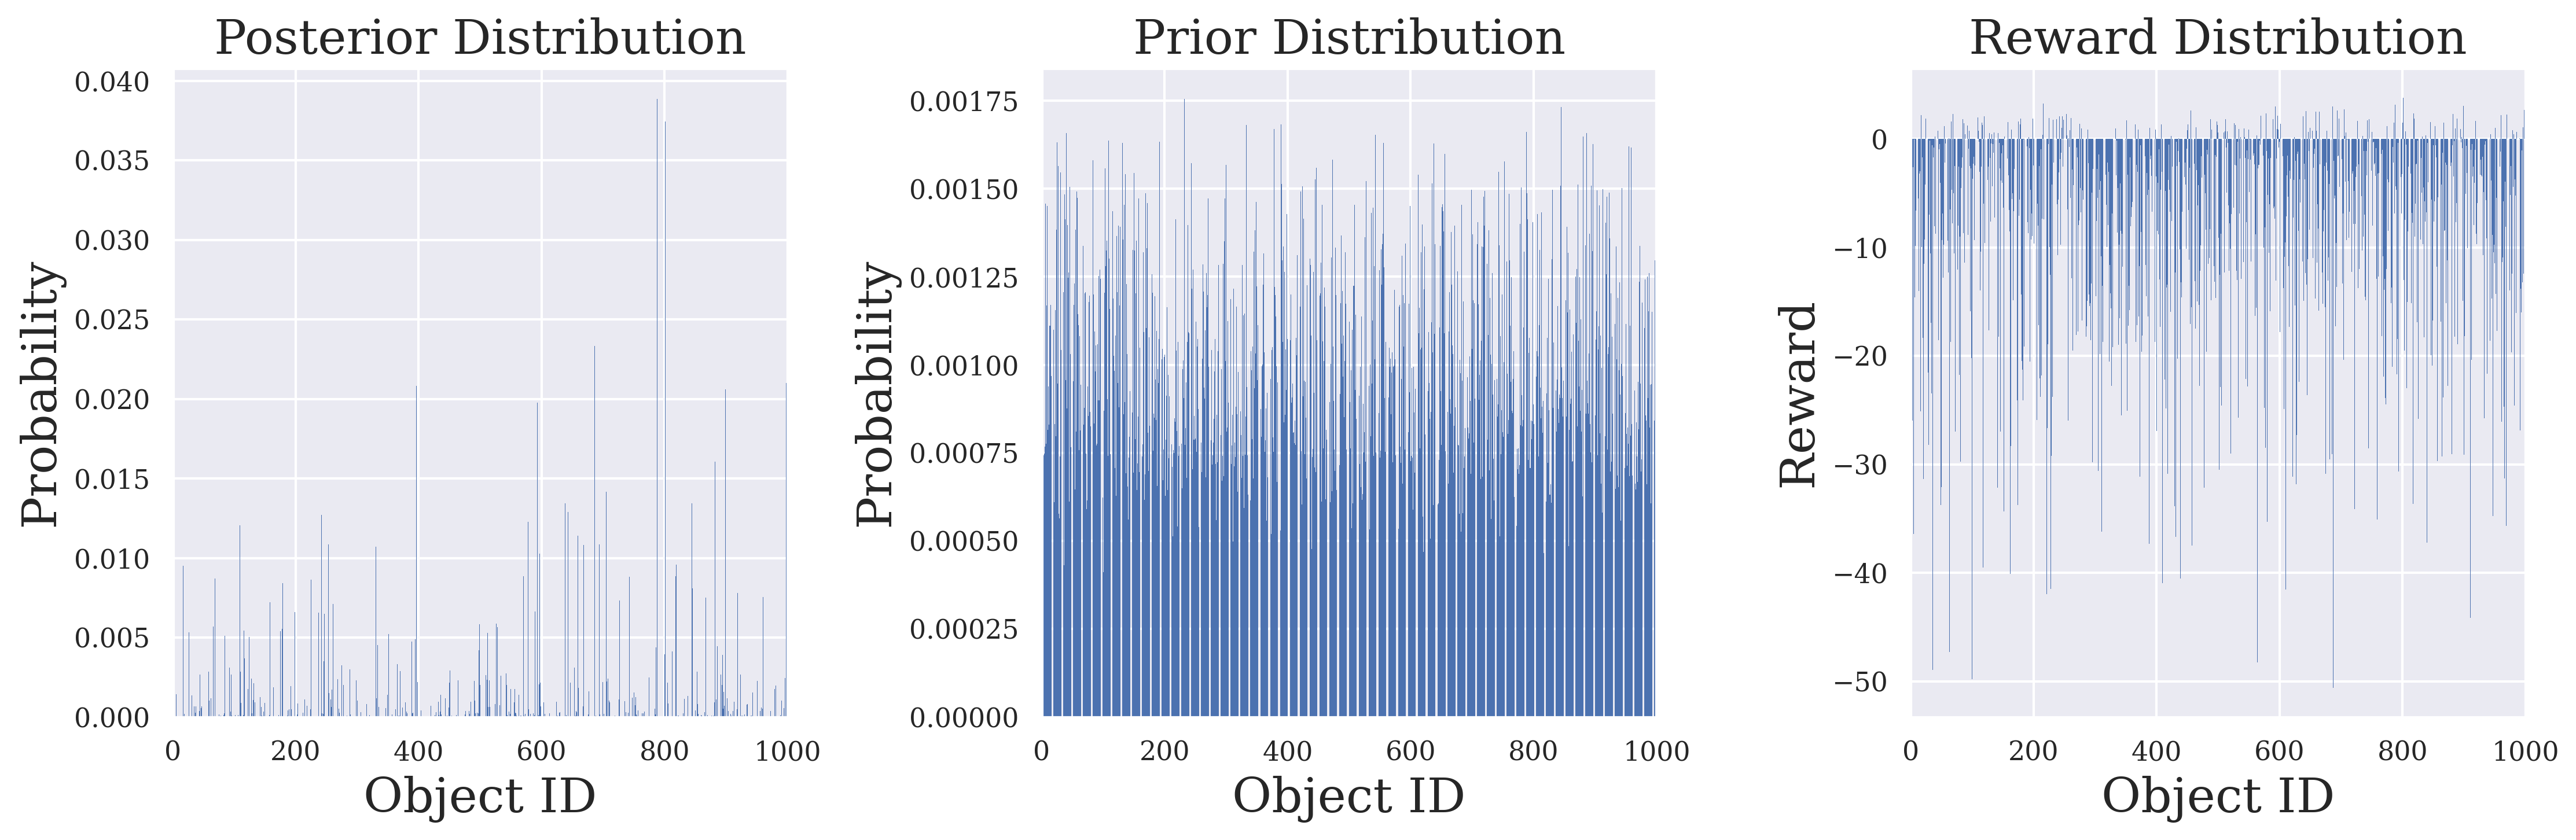

Joint Entropy: 5.01, Prior Entropy: 6.87
Typical Corpora: 213/1000


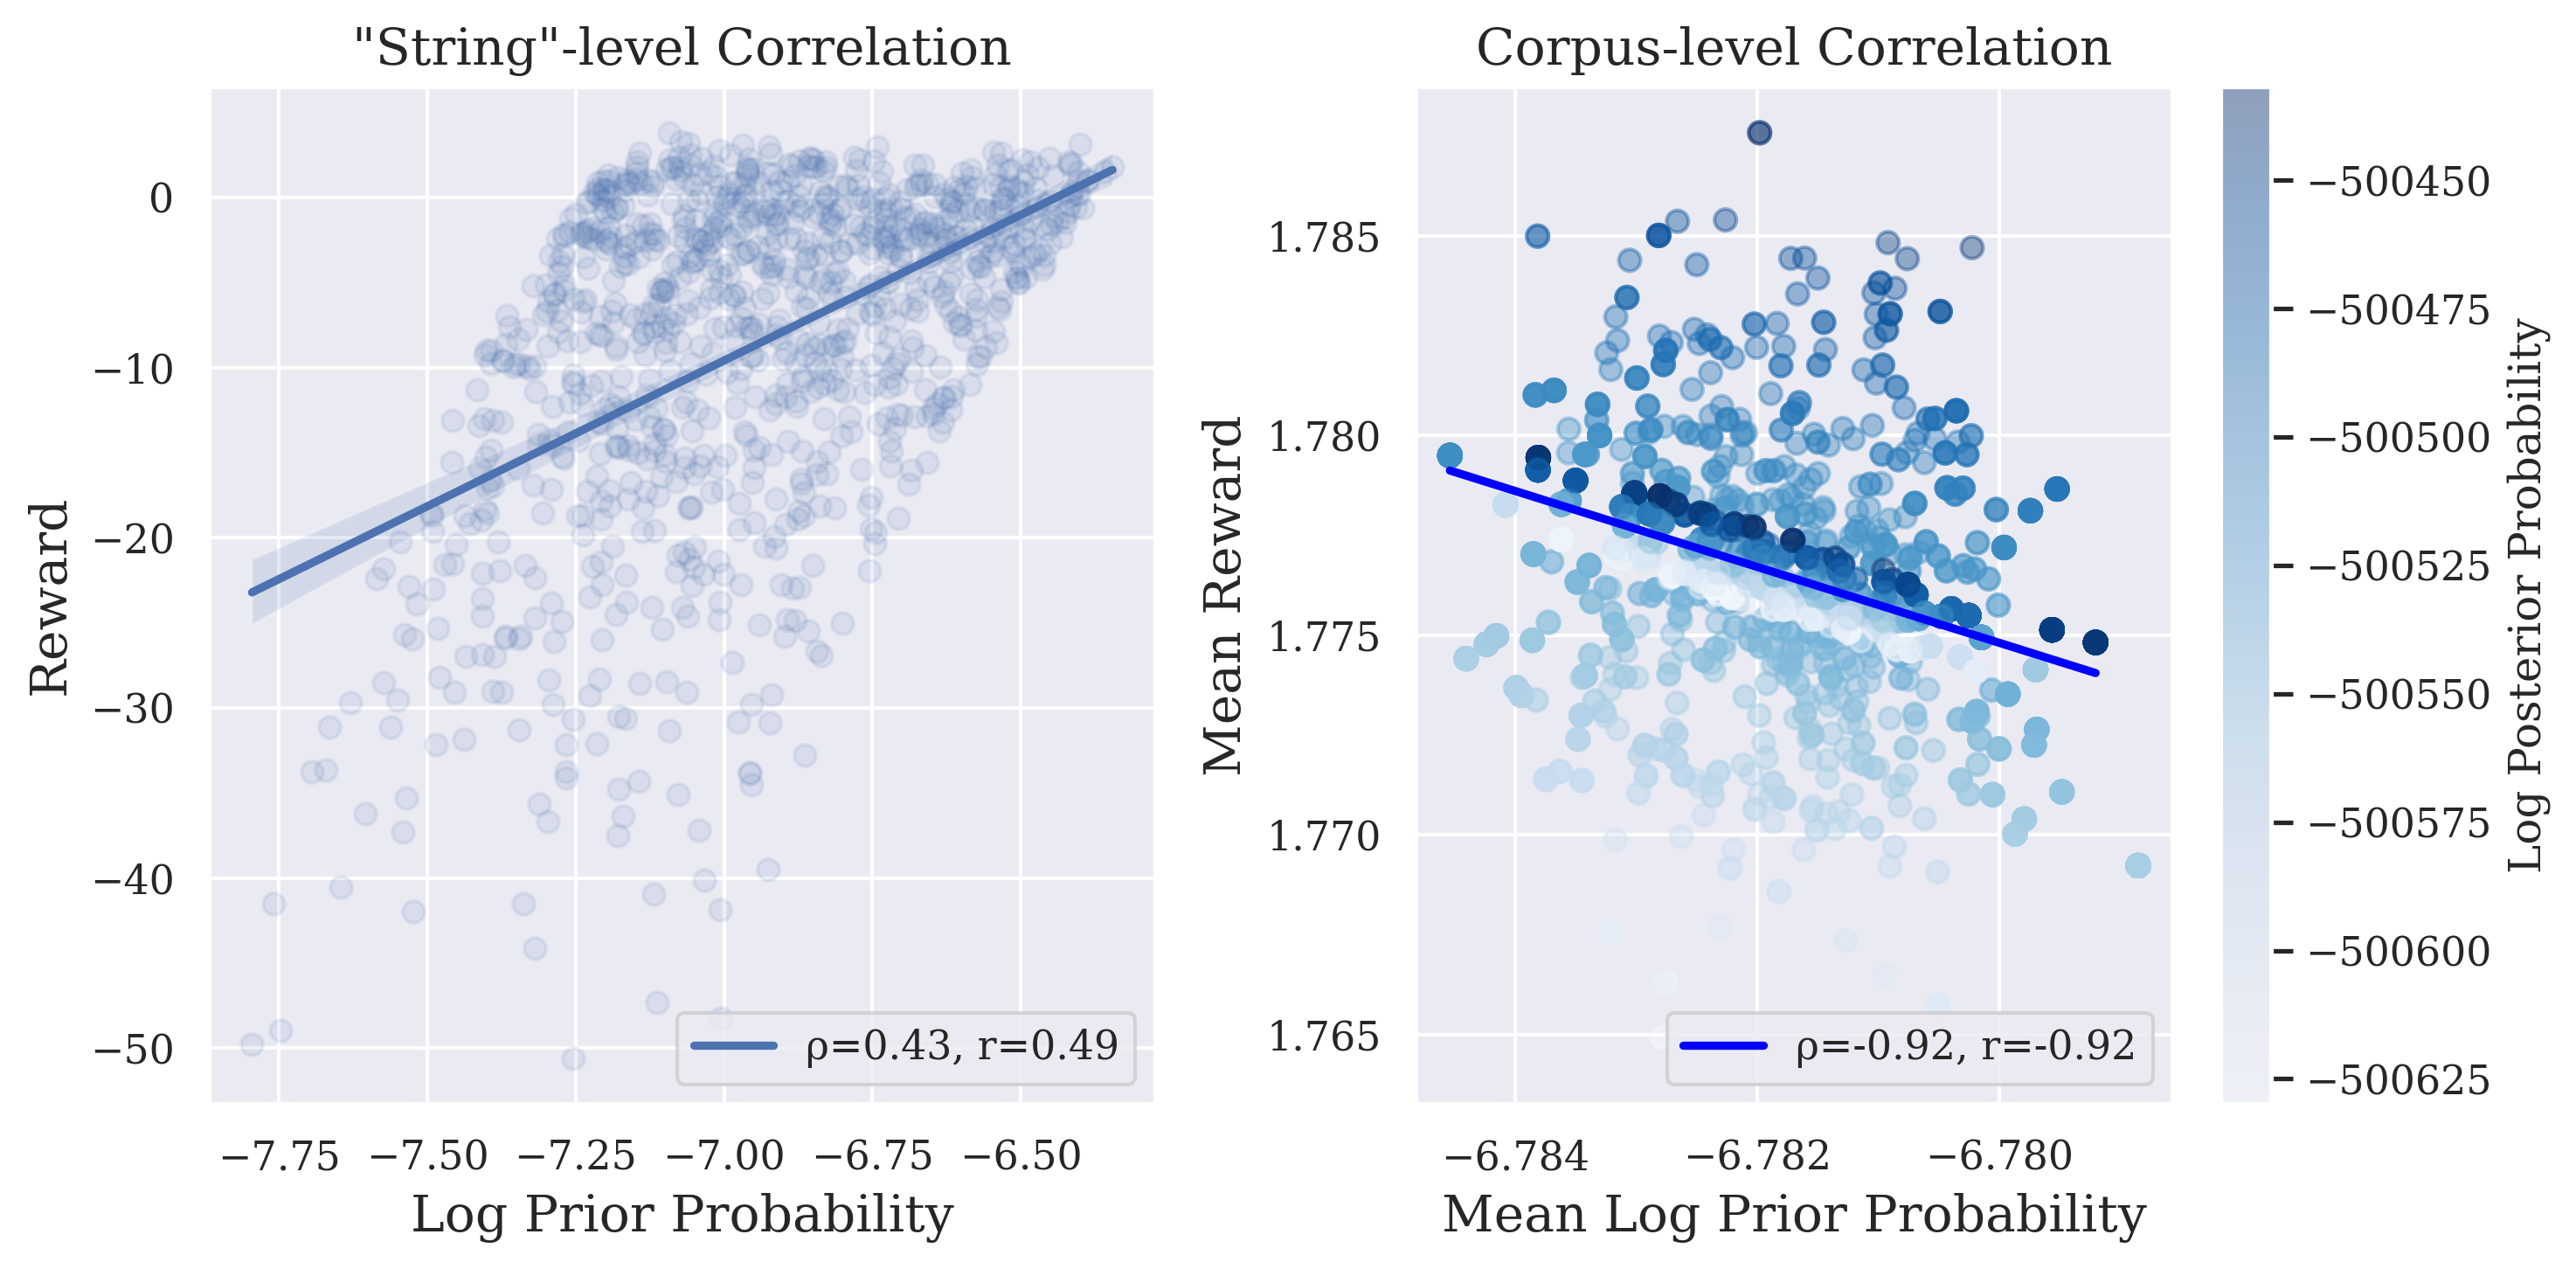

In [172]:
# 1. create p(y|A=+), p(y) and r(y), such that p(y) and r(y) are correlated
np.random.seed(seed)
p_y_A = dirichlet(alpha=[alpha] * domain_size, size=1).flatten()
p_y = softmax(
    torch.from_numpy(p_y_A) ** (1 / scaling)
    + np.random.uniform(-noise, noise, size=domain_size),
    dim=0,
).numpy()
reward = np.log(p_y_A / p_y)
assert np.allclose(np.sum(p_y_A), 1)
assert np.allclose(np.sum(p_y), 1)
assert np.all(p_y_A > 0)
assert np.all(p_y > 0)

# 1.1 plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
ax[0].bar(range(domain_size), p_y_A, edgecolor="none")
ax[0].set_title("Posterior Distribution", fontsize=20)
ax[0].set_ylabel("Probability", fontsize=20)

ax[1].bar(range(domain_size), p_y, edgecolor="none")
ax[1].set_title("Prior Distribution", fontsize=20)
ax[1].set_ylabel("Probability", fontsize=20)


ax[2].bar(range(domain_size), reward, edgecolor="none")
ax[2].set_title("Reward Distribution", fontsize=20)
ax[2].set_ylabel("Reward", fontsize=20)

for a in ax:
    a.set_xlabel("Object ID", fontsize=20)
    a.set_xlim(0, domain_size)

plt.tight_layout()
plt.show()
plt.close()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

# 2. compute
entropy = -np.sum(p_y_A * np.log(p_y_A))
prior_entropy = -np.sum(p_y * np.log(p_y))
print(f"Joint Entropy: {entropy:.2f}, Prior Entropy: {prior_entropy:.2f}")

# 3. plot correlation between log p(y) and r(y)
log_p_y = np.log(p_y)
spearman = spearmanr(log_p_y, reward)[0]
pearson = pearsonr(log_p_y, reward)[0]
ax[0].set_title('"String"-level Correlation', fontsize=14)
ax[0].scatter(log_p_y, reward, alpha=0.1)
sns.regplot(
    data=pd.DataFrame({"log_p_y": log_p_y, "reward": reward}),
    x="log_p_y",
    y="reward",
    label=f"ρ={spearman:.2f}, r={pearson:.2f}",
    scatter=False,
    ax=ax[0],
)
ax[0].set_xlabel("Log Prior Probability", fontsize=14)
ax[0].set_ylabel("Reward", fontsize=14)
ax[0].legend()


# 4. sample corpora from p(y|A=+)
typical_corpora = []
atypical_corpora = []
for corpus_id in range(num_corpora):
    np.random.seed(corpus_id)
    corpus = np.random.choice(range(domain_size), size=num_per_corpus, p=p_y_A)
    sample_p_y_A = np.array([p_y_A[i] for i in corpus])
    sample_p_y = np.array([p_y[i] for i in corpus])
    sample_reward = np.array([reward[i] for i in corpus])

    # 4.1 check for typicality
    sample_entropy = -np.mean(np.log(sample_p_y_A))
    is_typical = np.abs(entropy - sample_entropy) < epsilon

    if is_typical:
        typical_corpora.append((sample_p_y, sample_reward, sample_p_y_A))
    else:
        atypical_corpora.append((sample_p_y, sample_reward, sample_p_y_A))
print(f"Typical Corpora: {len(typical_corpora)}/{num_corpora}")


# 5. resample and plot typical and atypical corpora
corpora_sets_as_df = dict()
for corpora_set, corpora_set_label, plot_line in [
    (atypical_corpora, ("Atypical", "blue", "Blues"), False),
    (typical_corpora, ("Typical", "blue", "Blues"), True),
]:
    np.random.seed(seed)
    if len(corpora_set) <= 1:
        continue
    corpora_set = np.array(corpora_set)
    corpora_set_name, corpora_set_color, cmap = corpora_set_label
    corpora_set_log_p_y = np.log(corpora_set[:, 0, :])
    corpora_set_reward = corpora_set[:, 1, :]
    corpora_set_log_p_y_A = np.log(corpora_set[:, 2, :])
    corpora_mean_log_p_y = corpora_set_log_p_y.mean(axis=1)
    corpora_mean_reward = corpora_set_reward.mean(axis=1)
    corpora_total_log_p_y_A = corpora_set_log_p_y_A.sum(axis=1)
    corpora_set_as_df = pd.DataFrame({
        "mean_log_p_y": corpora_mean_log_p_y,
        "mean_reward": corpora_mean_reward,
        "log_p_y_A": corpora_total_log_p_y_A,
    })

    # 5.1 bin
    corpora_set_as_df["bin"] = pd.cut(
        corpora_set_as_df["mean_log_p_y"], bins=num_bins, labels=False
    )
    corpora_set_as_df = corpora_set_as_df.groupby("bin").sample(
        n=num_corpora_per_bin, replace=True
    )
    corpora_set_as_df["alpha"] = (
        MinMaxScaler()
        .fit_transform(
            np.clip(
                np.exp(
                    MinMaxScaler().fit_transform(
                        corpora_set_as_df["log_p_y_A"].values.reshape(-1, 1)
                    )
                ),
                0,
                20,
            ),
        )
        .flatten()
    )
    corpora_sets_as_df[corpora_set_name] = corpora_set_as_df

    # 5.2 plot
    mean_log_p_ys = corpora_set_as_df["mean_log_p_y"]
    mean_rewards = corpora_set_as_df["mean_reward"]
    log_p_Y_As = corpora_set_as_df["log_p_y_A"]
    alphas = corpora_set_as_df["alpha"]
    im = ax[1].scatter(mean_log_p_ys, mean_rewards, c=log_p_Y_As, cmap=cmap, alpha=0.4)

    if plot_line:
        spearman = spearmanr(mean_rewards, mean_log_p_ys)[0]
        pearson = pearsonr(mean_rewards, mean_log_p_ys)[0]
        sns.regplot(
            data=corpora_set_as_df,
            x="mean_log_p_y",
            y="mean_reward",
            label=f"ρ={spearman:.2f}, r={pearson:.2f}",
            color=corpora_set_color,
            scatter=False,
            ax=ax[1],
        )

ax[1].set_title("Corpus-level Correlation", fontsize=14)
ax[1].set_ylabel("Mean Reward", fontsize=14)
ax[1].set_xlabel("Mean Log Prior Probability", fontsize=14)
fig.colorbar(im, ax=ax[1]).set_label(label="Log Posterior Probability")

for a in ax:
    a.legend()

plt.tight_layout()
plt.show()
plt.close()

In [176]:
# 6. compute stats
corpora_sets_as_df["Typical"].describe()

,mean_log_p_y,mean_reward,log_p_y_A,bin,alpha
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-6.781878,1.776591,-500528.662324,4.500000,0.433721
std,0.001489,0.001536,60.096496,2.873719,0.305723
min,-6.784543,1.774097,-500629.931891,0.000000,0.000000
25%,-6.783097,1.775414,-500581.787445,2.000000,0.160126
50%,-6.781868,1.776393,-500523.782962,4.500000,0.412606
75%,-6.780637,1.777991,-500476.271321,7.000000,0.682212
max,-6.779207,1.779500,-500431.853344,9.000000,1.000000


In [174]:
corpora_sets_as_df["Atypical"].describe()

,mean_log_p_y,mean_reward,log_p_y_A,bin,alpha
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-6.781603,1.775201,-500640.233879,4.500000,0.380125
std,0.001620,0.004189,394.163434,2.873719,0.167667
min,-6.784408,1.764414,-501785.212714,0.000000,0.000000
25%,-6.782975,1.772155,-500962.232714,2.000000,0.244676
50%,-6.781638,1.774776,-500718.745051,4.500000,0.335126
75%,-6.780263,1.778532,-500326.680110,7.000000,0.502023
max,-6.778854,1.787581,-499440.238123,9.000000,1.000000


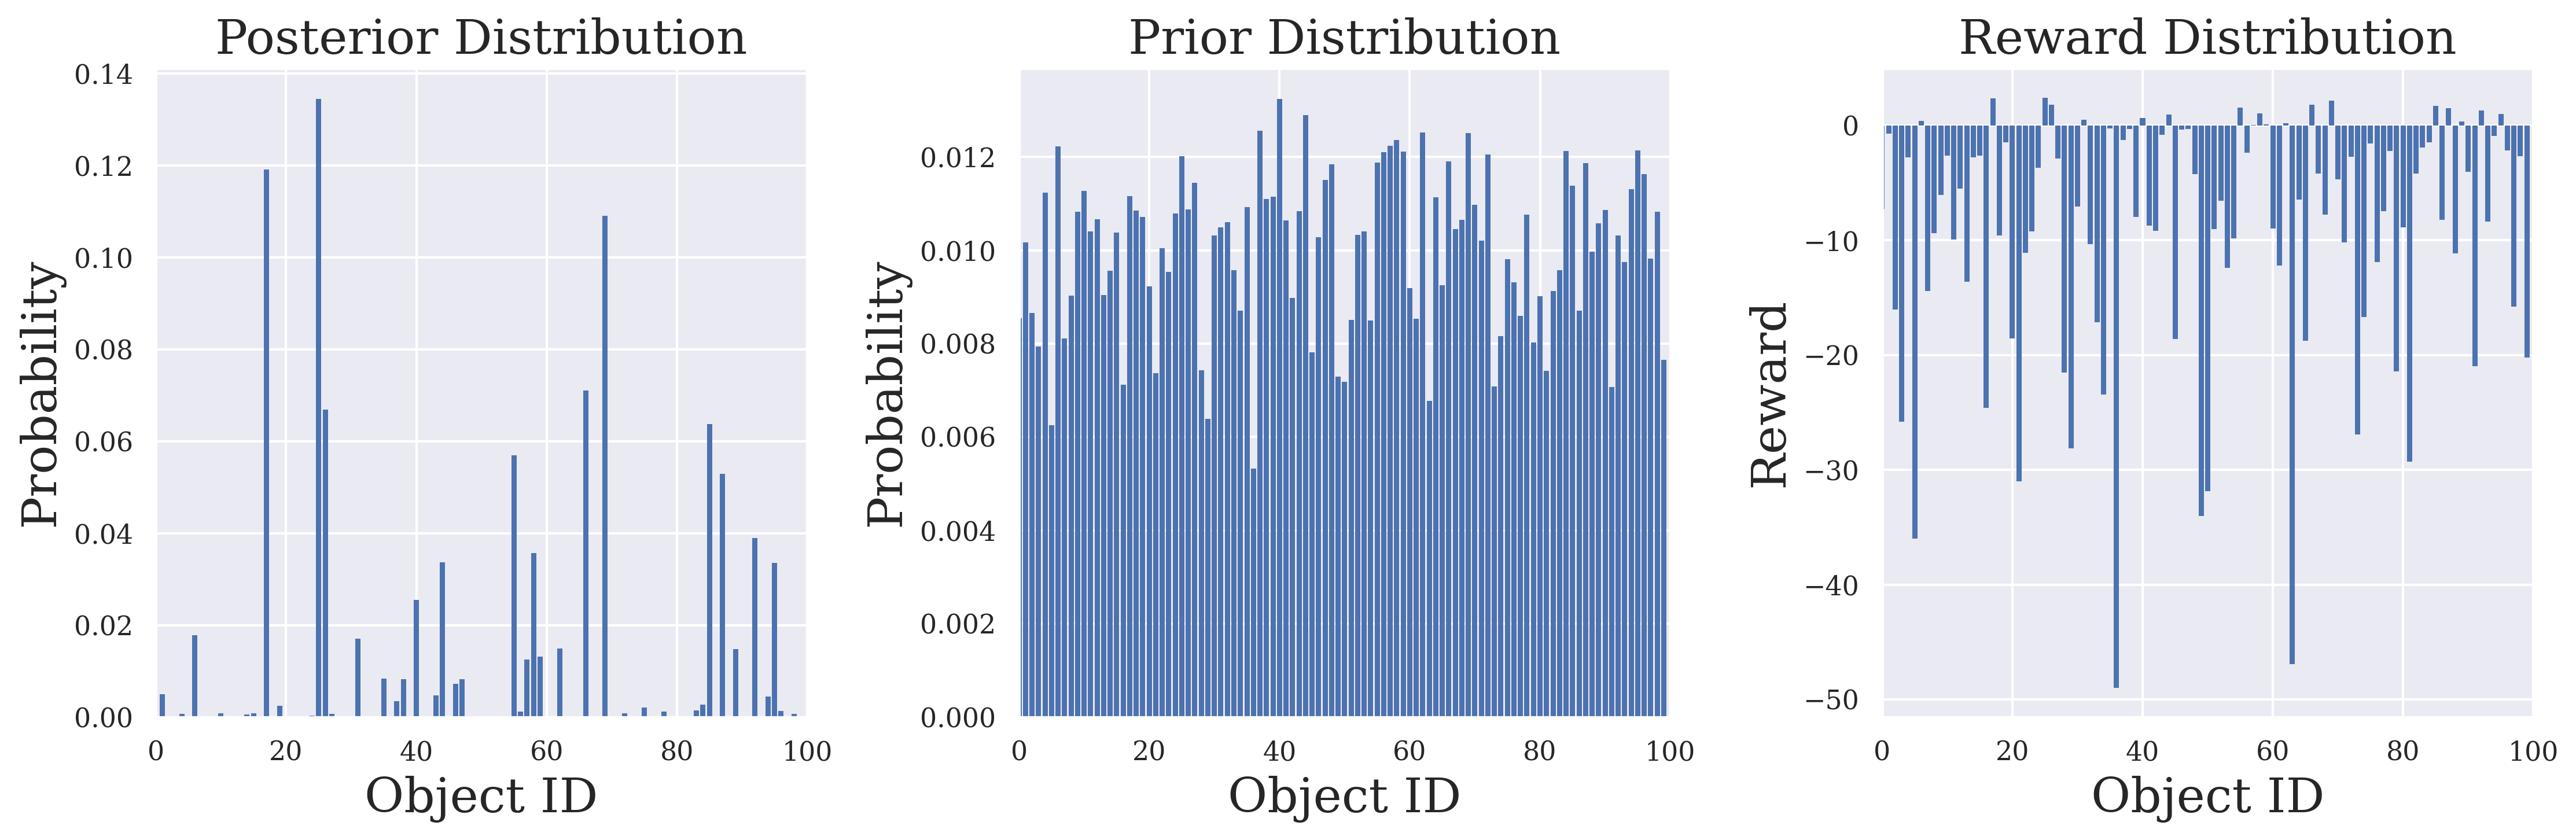

Joint Entropy: 2.95
Typical Corpora: 100/100
Skipping Atypical corpora


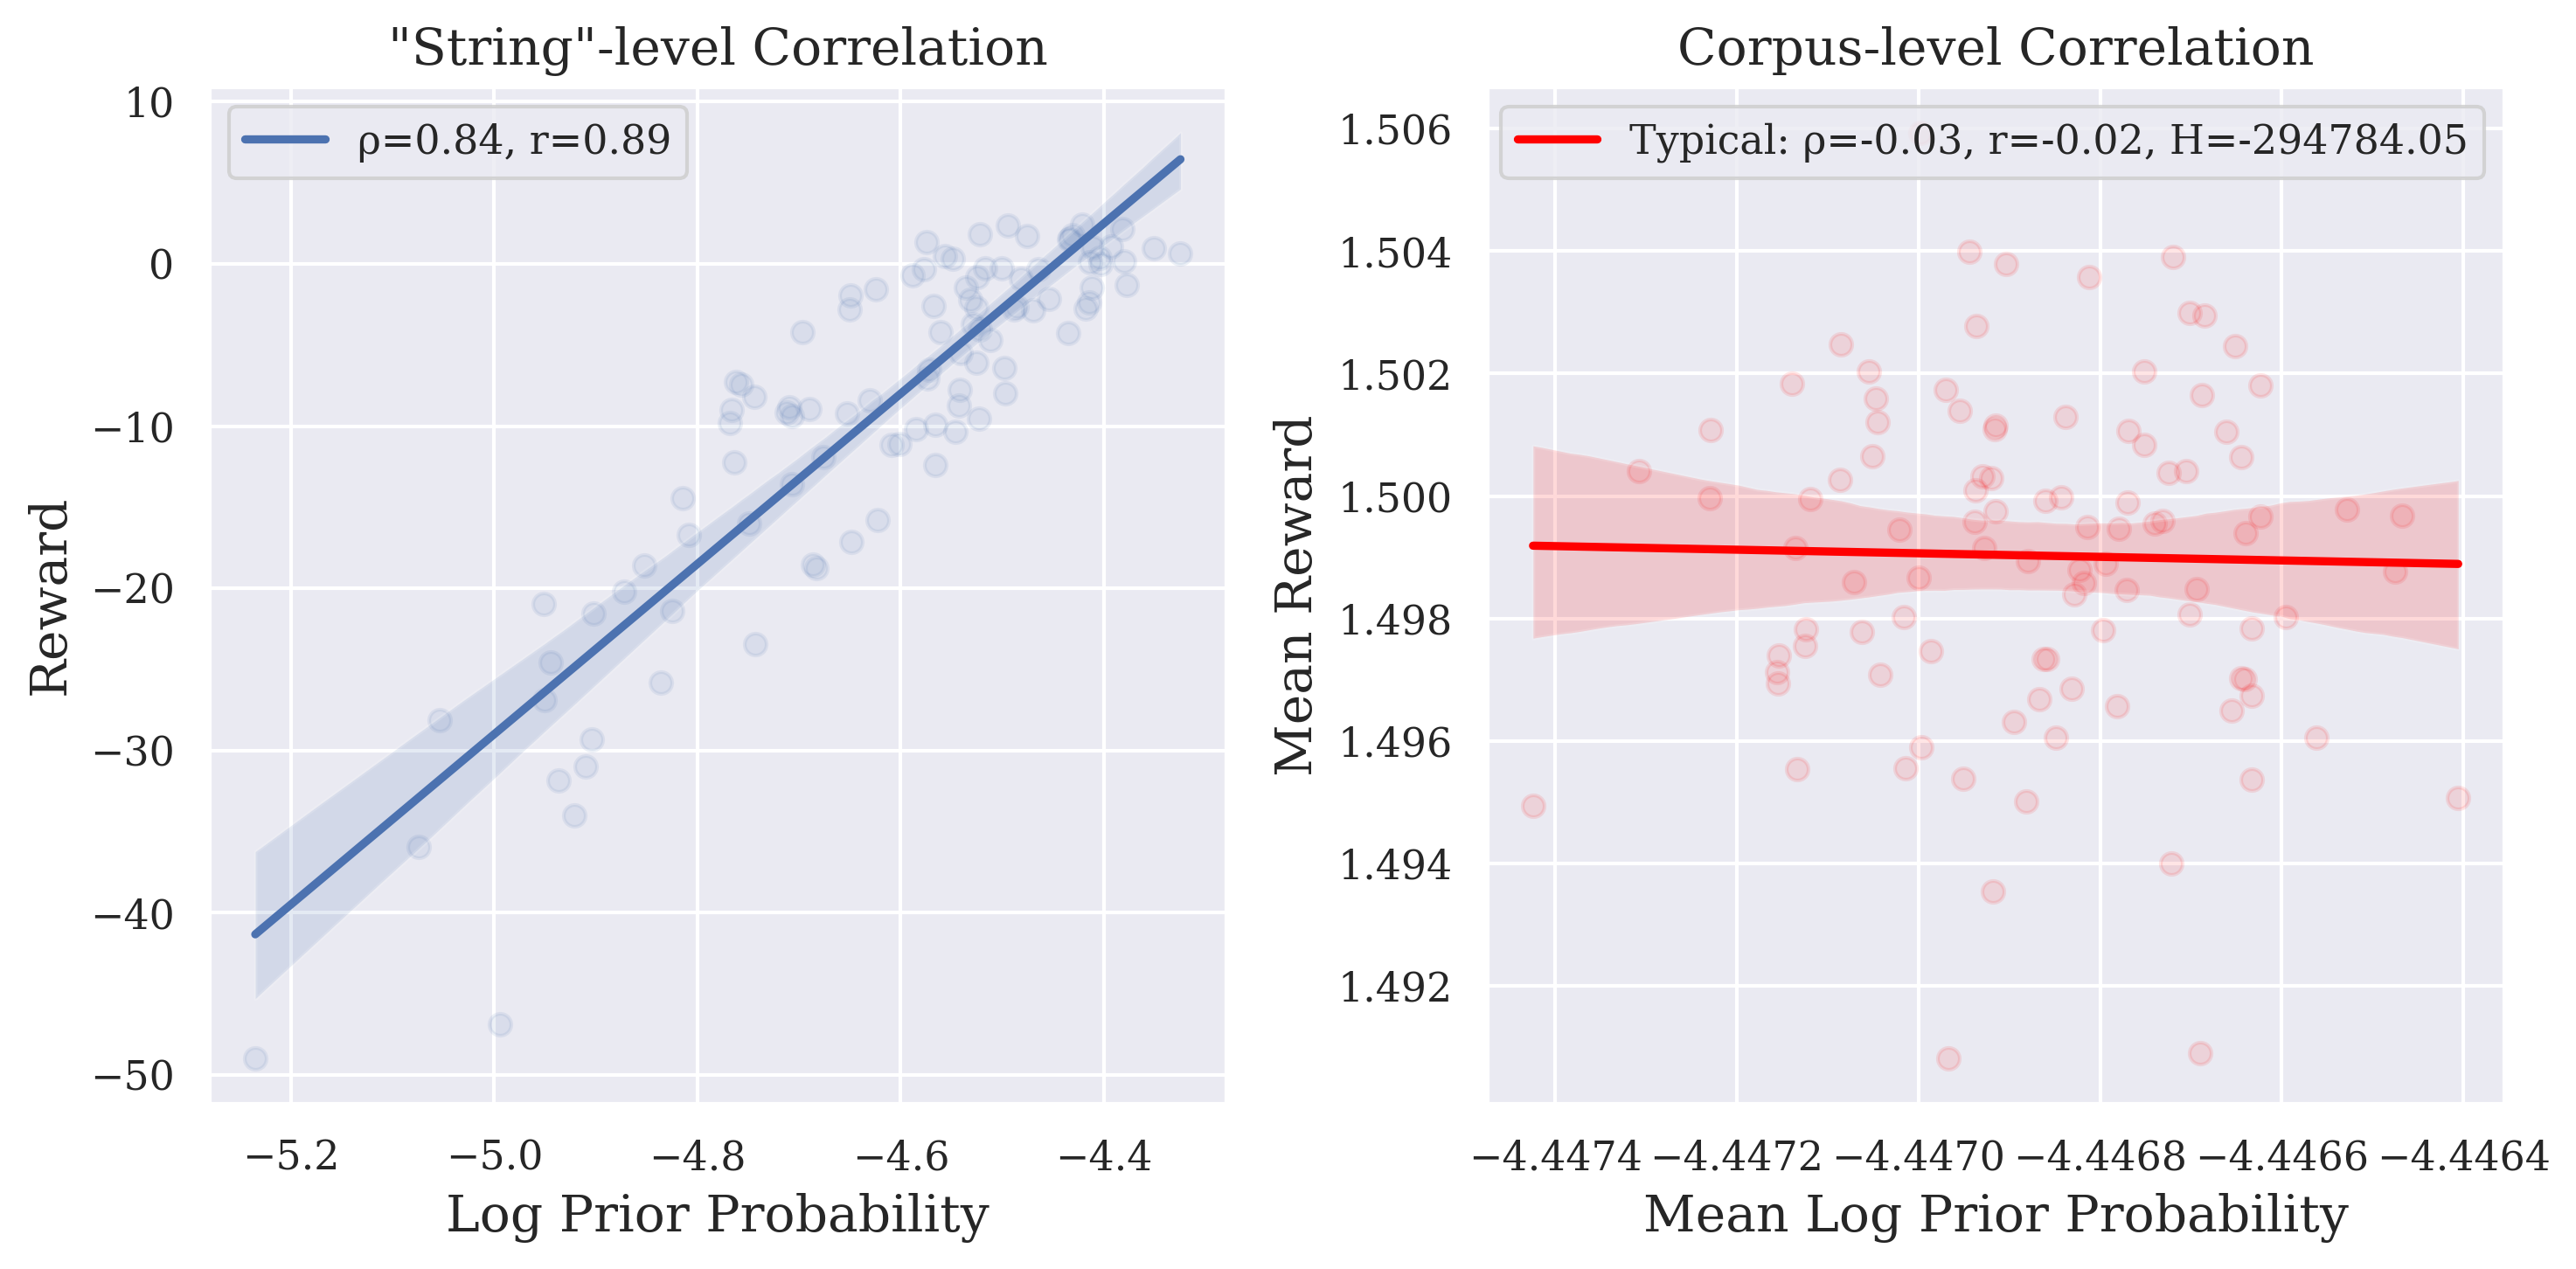

In [28]:
# 1. create p(y|A=+), p(y) and r(y), such that p(y) and r(y) are correlated
np.random.seed(seed)
p_y_A = dirichlet(alpha=[alpha] * domain_size, size=1).flatten()
p_y = softmax(
    torch.from_numpy(p_y_A) ** (1 / scaling)
    + np.random.uniform(-noise, noise, size=domain_size),
    dim=0,
).numpy()
reward = np.log(p_y_A / p_y)
assert np.allclose(np.sum(p_y_A), 1)
assert np.allclose(np.sum(p_y), 1)

# 1.1 plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
ax[0].bar(range(domain_size), p_y_A, edgecolor="none")
ax[0].set_title("Posterior Distribution", fontsize=20)
ax[0].set_ylabel("Probability", fontsize=20)

ax[1].bar(range(domain_size), p_y, edgecolor="none")
ax[1].set_title("Prior Distribution", fontsize=20)
ax[1].set_ylabel("Probability", fontsize=20)


ax[2].bar(range(domain_size), reward, edgecolor="none")
ax[2].set_title("Reward Distribution", fontsize=20)
ax[2].set_ylabel("Reward", fontsize=20)

for a in ax:
    a.set_xlabel("Object ID", fontsize=20)
    a.set_xlim(0, domain_size)

plt.tight_layout()
plt.show()
plt.close()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

# 2. plot correlation between log p(y) and r(y)
log_p_y = np.log(p_y)
spearman = spearmanr(log_p_y, reward)[0]
pearson = pearsonr(log_p_y, reward)[0]
ax[0].set_title('"String"-level Correlation', fontsize=14)
ax[0].scatter(log_p_y, reward, alpha=0.1)
sns.regplot(
    data=pd.DataFrame({"log_p_y": log_p_y, "reward": reward}),
    x="log_p_y",
    y="reward",
    label=f"ρ={spearman:.2f}, r={pearson:.2f}",
    scatter=False,
    ax=ax[0],
)
ax[0].set_xlabel("Log Prior Probability", fontsize=14)
ax[0].set_ylabel("Reward", fontsize=14)
ax[0].legend()


# 3. compute entropy
entropy = -np.sum(p_y_A * np.log(p_y_A))
print(f"Joint Entropy: {entropy:.2f}")

# 4. sample corpora from p(y|A=+)
typical_corpora = []
atypical_corpora = []
for corpus_id in range(num_corpora):
    np.random.seed(corpus_id)
    corpus = np.random.choice(range(domain_size), size=num_per_corpus, p=p_y_A)
    sample_p_y_A = np.array([p_y_A[i] for i in corpus])
    sample_p_y = np.array([p_y[i] for i in corpus])
    sample_reward = np.array([reward[i] for i in corpus])

    # 4.1 check for typicality
    sample_entropy = -np.mean(np.log(sample_p_y_A))
    is_typical = np.abs(entropy - sample_entropy) < epsilon

    if is_typical:
        typical_corpora.append((sample_p_y, sample_reward, sample_p_y_A))
    else:
        atypical_corpora.append((sample_p_y, sample_reward, sample_p_y_A))
print(f"Typical Corpora: {len(typical_corpora)}/{num_corpora}")

# 5. plot typical and atypical corpora
for corpora_set, corpora_set_label in [
    (atypical_corpora, ("Atypical", "blue")),
    (typical_corpora, ("Typical", "red")),
]:
    corpora_set_name, corpora_set_color = corpora_set_label

    # 5.1 scatter plot
    mean_rewards = []
    mean_log_p_ys = []
    log_p_Y_As = []
    for sample_p_y, sample_reward, sample_p_y_A in corpora_set:
        mean_reward = np.mean(sample_reward)
        mean_log_p_y = np.mean(np.log(sample_p_y))
        assert np.isclose(
            np.log(sample_p_y_A).sum(),
            np.log(sample_p_y).sum() + np.log(sample_p_y_A / sample_p_y).sum(),
        ), (
            f"{np.log(sample_p_y_A).sum()} != {np.log(sample_p_y).sum()} +"
            f" {np.sum(sample_reward)}"
        )
        ax[1].scatter(mean_log_p_y, mean_reward, color=corpora_set_color, alpha=0.1)

        # append to track
        mean_rewards.append(mean_reward)
        mean_log_p_ys.append(mean_log_p_y)
        log_p_Y_As.append(np.log(sample_p_y_A).sum())

    # 5.2 compute
    if len(corpora_set) < 2:
        print(f"Skipping {corpora_set_name} corpora")
        continue
    spearman = spearmanr(mean_rewards, mean_log_p_ys)[0]
    pearson = pearsonr(mean_rewards, mean_log_p_ys)[0]
    sns.regplot(
        data=pd.DataFrame({"mean_reward": mean_rewards, "mean_log_p_y": mean_log_p_ys}),
        x="mean_log_p_y",
        y="mean_reward",
        label=(
            f"{corpora_set_name}: ρ={spearman:.2f}, r={pearson:.2f},"
            f" H={np.mean(log_p_Y_As):.2f}"
        ),
        color=corpora_set_color,
        scatter=False,
        ax=ax[1],
    )
ax[1].set_title("Corpus-level Correlation", fontsize=14)
ax[1].set_ylabel("Mean Reward", fontsize=14)
ax[1].set_xlabel("Mean Log Prior Probability", fontsize=14)

for a in ax:
    a.legend()

plt.tight_layout()
plt.show()
plt.close()